<a href="https://colab.research.google.com/github/rsotop/Anal-tica-de-negocio/blob/main/Lab_Transformaci%C3%B3n_WoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformación del Peso de la Evidencia (Weight of Evidence)

En esta práctica de laboratorio, aplicaremos una transformación de Peso de la evidencia a nuestros datos. La idea es:

- Divida los datos en un conjunto de prueba/entrenamiento.
- Generar un conjunto relevante de cortes a nuestros datos.
- Calcule el WoE para cada variable.
- Guarde los datos que acabamos de crear.

Suponemos que ya hemos limpiado la fecha de valores atípicos y nulos.

Para ello utilizaremos el fantástico paquete de Python [```scorecardpy```](https://github.com/ShichenXie/scorecardpy). Primero necesitamos instalarlo, ya que no es un paquete estándar.

We use the OS python software ```pip``` para esto.

In [1]:
!pip install scorecardpy

     |████████████████████████████████| 55 kB 1.7 MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57843 sha256=15886a3bab0fda999a2d28b986827765a79f4a9e98e72b07c65030a87ab6b294
  Stored in directory: /root/.cache/pip/wheels/9d/50/52/715367c478fd2e2317070ccf6539b2c29fc8168144cfbfaeac
Successfully built scorecardpy


Ahora importamos los datos a utilizar. Creé una versión limpia del conjunto de datos de nuestro último laboratorio.

---



In [2]:
import pandas as pd
!gdown 'https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs'
bankloan_data = pd.read_pickle('BankloanClean.pkl')
bankloan_data.describe()

Downloading...
From: https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs
To: /content/BankloanClean.pkl
100% 135k/135k [00:00<00:00, 75.3MB/s]


,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000
mean,257649.480188,34.003358,6.799866,6.233714,56.898590,9.904835,1.801370,3.664231,0.366850,0.361988
std,139646.983244,12.982437,8.765093,5.987928,55.062182,6.649132,2.340326,4.665854,0.294387,0.480737
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98410.000000,24.000000,0.000000,2.000000,27.000000,4.800000,0.420000,1.100000,0.150000,0.000000
50%,316013.000000,31.000000,4.000000,5.000000,39.000000,8.500000,0.980000,2.200000,0.290000,0.000000
75%,370695.000000,41.000000,10.000000,9.000000,63.000000,13.500000,2.170000,4.500000,0.500000,1.000000
max,453777.000000,79.000000,63.000000,34.000000,533.000000,40.700000,19.050000,52.650000,2.150000,1.000000


Siempre es una buena idea crear nuevas variables para extraer información de nuestros modelos. Por ejemplo, la siguiente variable mejora OthDebt.

In [3]:
bankloan_data['OthDebtRatio'] = bankloan_data['OthDebt'] / bankloan_data['Income']

## Binning
El primer paso es agrupar correctamente los datos. Por lo general, ejecutaremos un árbol y ajustaremos manualmente aquellos casos que no sigan un patrón lógico.

Sin embargo, dado que calcular WoE significa que necesitamos usar la variable objetivo, primero debemos crear una división de entrenamiento y prueba. El paquete *scorecard* viene con una función para hacerlo fácilmente, ```split_df``` que toma como argumento la relación y la semilla.

**Nota: Se utiliza una semilla aleatoria para generar una división aleatoria que será reproducible (¿existe la aleatoriedad en una computadora?). Espero que para todos los cursos use su identificación de estudiante.**

In [4]:
import scorecardpy as sc
import numpy as np

In [5]:
# Divida en entrenamiento y pruebe ANTES de que apliquemos WoE 
# ¡Use su identificación de estudiante como semilla!

train, test = sc.split_df(bankloan_data.iloc[:,1:],
                          y = 'Default',
                          ratio = 0.7, seed = 20190227).values()

In [6]:
train.describe()

,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default,OthDebtRatio
count,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000
mean,34.146833,6.849328,6.289827,56.221689,9.797889,1.766612,3.602294,0.361238,0.361804,0.065745
std,13.121634,8.751854,6.055655,51.342681,6.589095,2.252177,4.429818,0.291971,0.480753,0.048982
min,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,2.000000,28.000000,4.700000,0.420000,1.072500,0.150000,0.000000,0.028521
50%,31.000000,4.000000,5.000000,39.000000,8.400000,0.980000,2.205000,0.290000,0.000000,0.053353
75%,41.750000,9.000000,9.000000,62.000000,13.400000,2.127500,4.560000,0.490000,1.000000,0.090714
max,77.000000,53.000000,33.000000,526.000000,38.800000,18.120000,52.650000,2.150000,1.000000,0.306400


Ahora podemos agrupar las variables. La función ```woebin``` hará esto automáticamente por nosotros. Utilizará árboles secuencialmente dadas las restricciones que decidamos. Es una buena práctica no dejar menos del 5 % de los casos en cada contenedor, y estoy usando 20 contenedores iniciales (bins).

**Sugerencia: para conjuntos de datos más grandes, use una cantidad relativamente grande de contenedores (50 a 100), para conjuntos más pequeños, use menos.**

In [7]:
bins = sc.woebin(train, y = 'Default', 
                 min_perc_fine_bin=0.05, # En cuántos contenedores cortar inicialmente
                 min_perc_coarse_bin=0.05,  # Porcentaje mínimo por contenedor final
                 stop_limit=0.1, # Valor mínimo de información 
                 max_num_bin=8, # Número máximo de contenedores
                 method='tree')

[INFO] creating woe binning ...


Ahora podemos graficar los resultados. Necesitamos poder explicar los resultados para cada variable. Deberíamos ser capaces de explicar cada tendencia. No es necesario que sean necesariamente lineales, solo necesitamos una buena explicación de la tendencia.

**Si no puede explicar la tendencia, debe ajustar los contenedores.**

{'Address': <Figure size 432x288 with 2 Axes>,
 'Age': <Figure size 432x288 with 2 Axes>,
 'Creddebt': <Figure size 432x288 with 2 Axes>,
 'Education': <Figure size 432x288 with 2 Axes>,
 'Employ': <Figure size 432x288 with 2 Axes>,
 'Income': <Figure size 432x288 with 2 Axes>,
 'Leverage': <Figure size 432x288 with 2 Axes>,
 'MonthlyLoad': <Figure size 432x288 with 2 Axes>,
 'OthDebt': <Figure size 432x288 with 2 Axes>,
 'OthDebtRatio': <Figure size 432x288 with 2 Axes>}

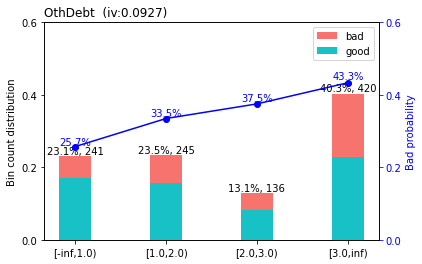

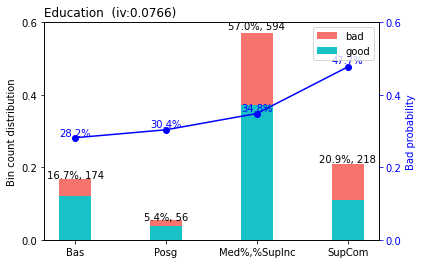

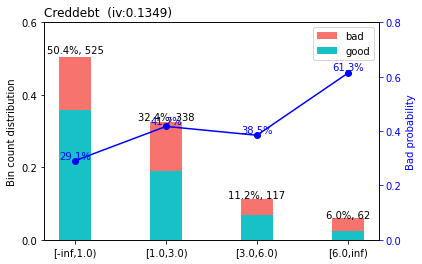

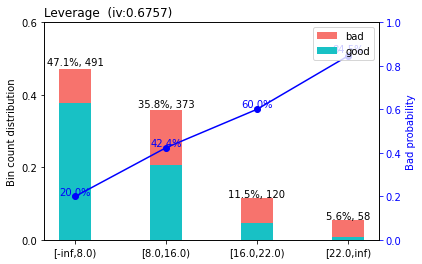

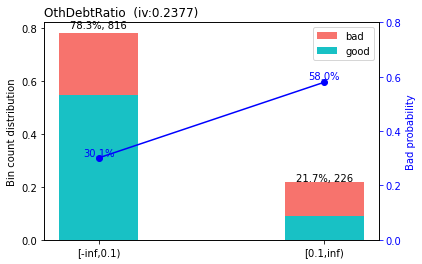

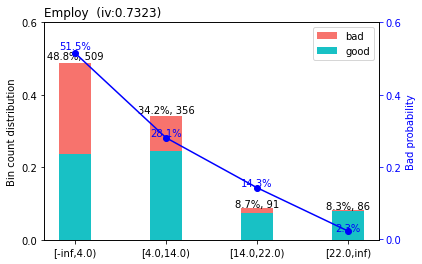

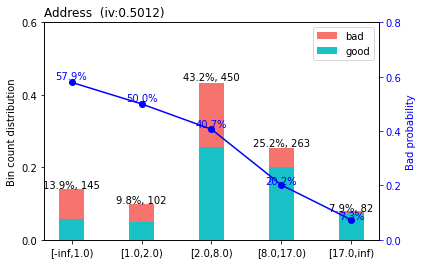

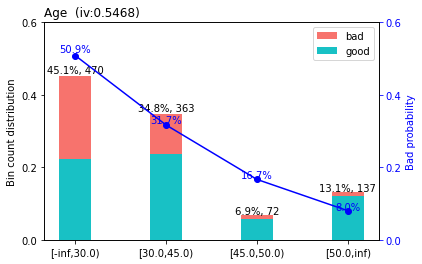

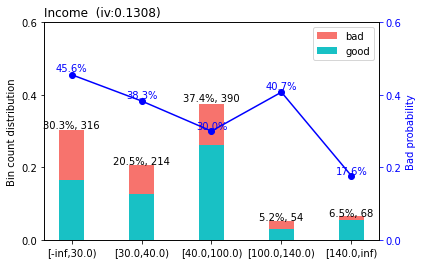

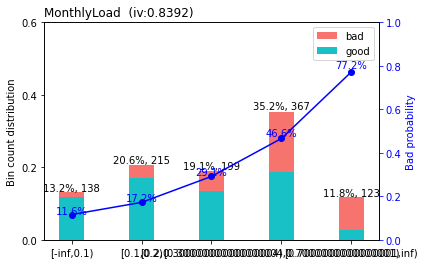

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sc.woebin_plot(bins)

In [9]:
bins

{'Address':   variable         bin  count  count_distr  good  bad   badprob       woe  \
 0  Address  [-inf,1.0)    145     0.139155    61   84  0.579310  0.887485   
 1  Address   [1.0,2.0)    102     0.097889    51   51  0.500000  0.567542   
 2  Address   [2.0,8.0)    450     0.431862   267  183  0.406667  0.189779   
 3  Address  [8.0,17.0)    263     0.252399   210   53  0.201521 -0.809274   
 4  Address  [17.0,inf)     82     0.078695    76    6  0.073171 -1.971432   
 
      bin_iv  total_iv breaks  is_special_values  
 0  0.116334  0.501228    1.0              False  
 1  0.033250  0.501228    2.0              False  
 2  0.015924  0.501228    8.0              False  
 3  0.141790  0.501228   17.0              False  
 4  0.193931  0.501228    inf              False  ,
 'Age':   variable          bin  count  count_distr  good  bad   badprob       woe  \
 0      Age  [-inf,30.0)    470     0.451056   231  239  0.508511  0.601588   
 1      Age  [30.0,45.0)    363     0.348369   

## Ajuste manual

En este caso, la deuda de crédito y los ingresos no siguen una tendencia explicable, por lo que debemos realizar ajustes manuales.

Tenga en cuenta que OthDebt tiene un Valor de Información (IV) de 0.0927. **El resultado de la función de agrupamiento es el mejor agrupamiento posible desde un punto de vista estadístico. Cambiarlo solo hará que IV baje**. Como el IV de OthDebt está muy cerca de 1, debe hacer una llamada. ¿Cuántas variables tienes disponibles? Si es suficiente, puede descartar la variable; de ​​lo contrario, debe dejarla y ver si esto se puede solucionar más adelante.

Ahora tenemos que ajustar la deuda de crédito y los ingresos. Esto lo podemos hacer de manera interactiva dentro del paquete con la excelente función ```woebin_adj``` que nos permite hacer ajustes uno por uno, solo para aquellas variables con tendencias irregulares (esto se puede cambiar en las opciones). Comenzamos invocando la función, observe la barra al final.

-------- 1/10 OthDebt --------
>>> dt[OthDebt].describe(): 
count    1042.000000
mean        3.602294
std         4.429818
min         0.000000
25%         1.072500
50%         2.205000
75%         4.560000
max        52.650000
Name: OthDebt, dtype: float64 



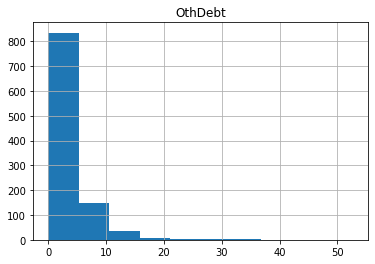

>>> Current breaks:
1.0,2.0,3.0 



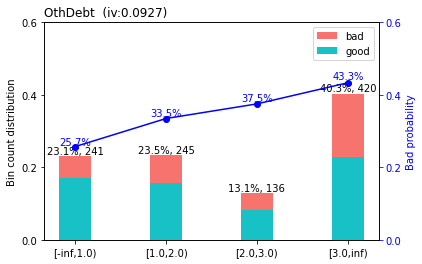

>>> Adjust breaks for (1/10) OthDebt?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/10 Education --------
>>> dt[Education].describe(): 
count     1042
unique       5
top        Med
freq       358
Name: Education, dtype: object 

>>> dt[Education].value_counts(): 
Med       358
SupInc    236
SupCom    218
Bas       174
Posg       56
Name: Education, dtype: int64 

>>> Current breaks:
'Bas','Posg','Med%,%SupInc','SupCom' 



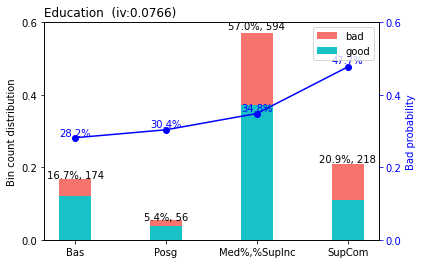

>>> Adjust breaks for (2/10) Education?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/10 Creddebt --------
>>> dt[Creddebt].describe(): 
count    1042.000000
mean        1.766612
std         2.252177
min         0.000000
25%         0.420000
50%         0.980000
75%         2.127500
max        18.120000
Name: Creddebt, dtype: float64 



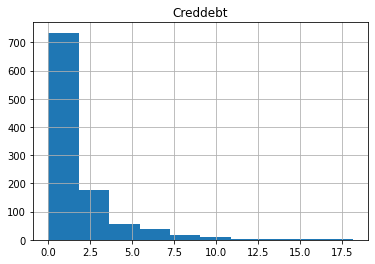

>>> Current breaks:
1.0,3.0,6.0 



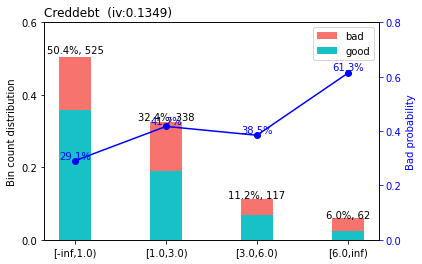

>>> Adjust breaks for (3/10) Creddebt?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 1.0, 6.0
[INFO] creating woe binning ...
>>> Current breaks:
6.0, 1.0 



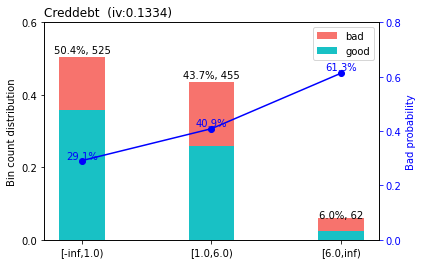

>>> Adjust breaks for (3/10) Creddebt?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/10 Leverage --------
>>> dt[Leverage].describe(): 
count    1042.000000
mean        9.797889
std         6.589095
min         0.000000
25%         4.700000
50%         8.400000
75%        13.400000
max        38.800000
Name: Leverage, dtype: float64 



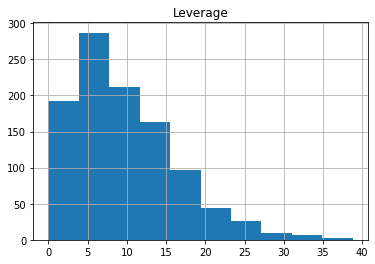

>>> Current breaks:
8.0,16.0,22.0 



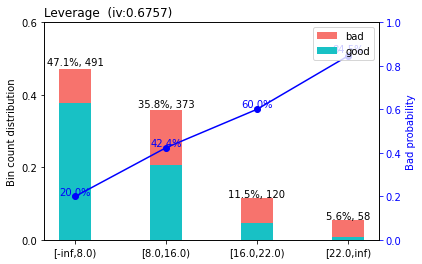

>>> Adjust breaks for (4/10) Leverage?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/10 OthDebtRatio --------
>>> dt[OthDebtRatio].describe(): 
count    1042.000000
mean        0.065745
std         0.048982
min         0.000000
25%         0.028521
50%         0.053353
75%         0.090714
max         0.306400
Name: OthDebtRatio, dtype: float64 



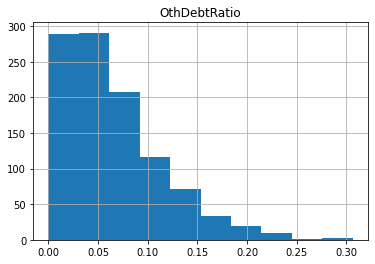

>>> Current breaks:
0.1 



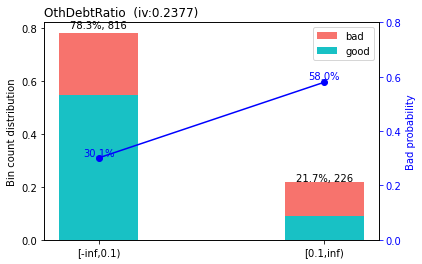

>>> Adjust breaks for (5/10) OthDebtRatio?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/10 Employ --------
>>> dt[Employ].describe(): 
count    1042.000000
mean        6.849328
std         8.751854
min         0.000000
25%         0.000000
50%         4.000000
75%         9.000000
max        53.000000
Name: Employ, dtype: float64 



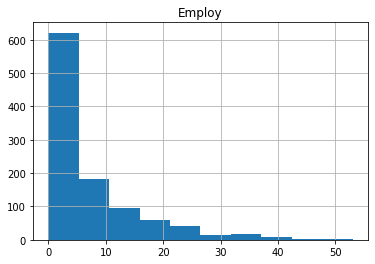

>>> Current breaks:
4.0,14.0,22.0 



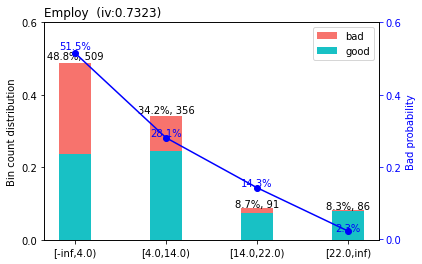

>>> Adjust breaks for (6/10) Employ?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/10 Address --------
>>> dt[Address].describe(): 
count    1042.000000
mean        6.289827
std         6.055655
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        33.000000
Name: Address, dtype: float64 



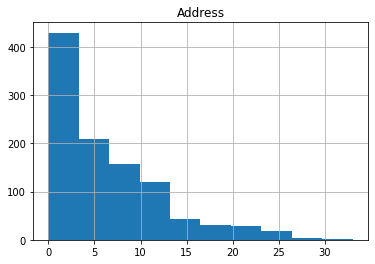

>>> Current breaks:
1.0,2.0,8.0,17.0 



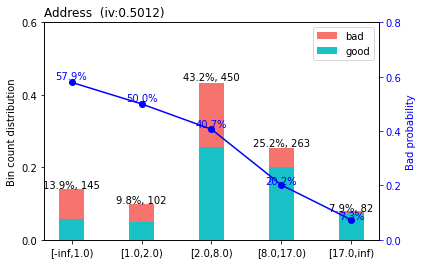

>>> Adjust breaks for (7/10) Address?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/10 Age --------
>>> dt[Age].describe(): 
count    1042.000000
mean       34.146833
std        13.121634
min        18.000000
25%        24.000000
50%        31.000000
75%        41.750000
max        77.000000
Name: Age, dtype: float64 



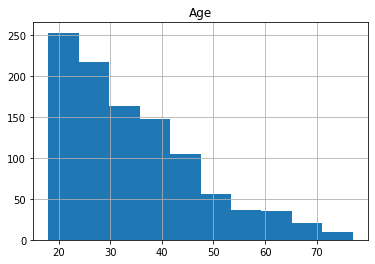

>>> Current breaks:
30.0,45.0,50.0 



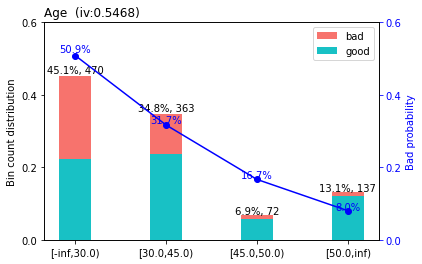

>>> Adjust breaks for (8/10) Age?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/10 Income --------
>>> dt[Income].describe(): 
count    1042.000000
mean       56.221689
std        51.342681
min        12.000000
25%        28.000000
50%        39.000000
75%        62.000000
max       526.000000
Name: Income, dtype: float64 



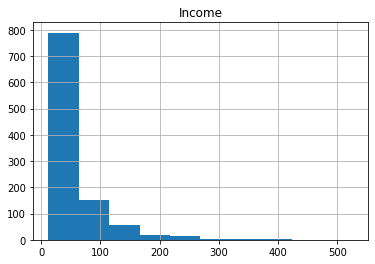

>>> Current breaks:
30.0,40.0,100.0,140.0 



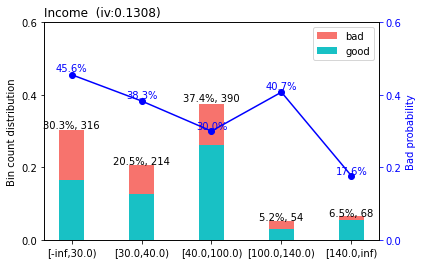

>>> Adjust breaks for (9/10) Income?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 30.0,40.0,80.0,140.0
[INFO] creating woe binning ...
>>> Current breaks:
40.0, 80.0, 140.0, 30.0 



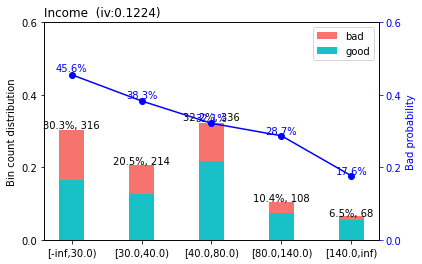

>>> Adjust breaks for (9/10) Income?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/10 MonthlyLoad --------
>>> dt[MonthlyLoad].describe(): 
count    1042.000000
mean        0.361238
std         0.291971
min         0.000000
25%         0.150000
50%         0.290000
75%         0.490000
max         2.150000
Name: MonthlyLoad, dtype: float64 



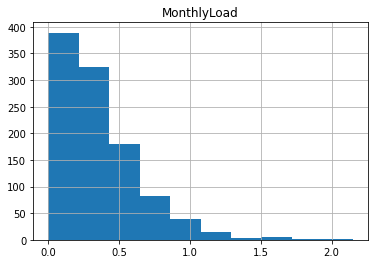

>>> Current breaks:
0.1,0.2,0.30000000000000004,0.7000000000000001 



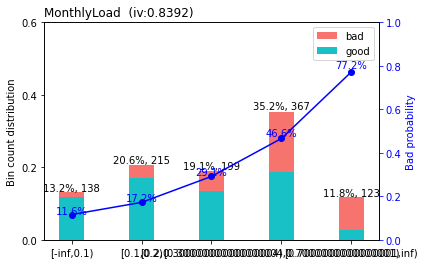

>>> Adjust breaks for (10/10) MonthlyLoad?
1: next 
2: yes 
3: back
Selection: 1


In [12]:
breaks_adj = sc.woebin_adj(train, "Default", bins, adj_all_var = True)

Para Creddebt necesitamos ingresar los siguientes quiebres:

```1.0, 6.0```

Y para Renta, ingresamos los siguientes quiebres:

```30.0,40.0,80.0,140.0```

Las variables ahora se comportan mucho mejor. Juega con los descansos para ver si puedes llegar a mejores soluciones. Los ingresos son una variable complicada: su IV es 0,13 en el agrupamiento original (incorrecto), pero el corregido está (muy ligeramente) por debajo de 0,1, por lo que sería descartado. ¿Deberíamos con una variable tan cercana a 1? Podríamos jugar un poco más para ver si podemos hacer que sea racional.

Ahora que estamos satisfechos con los agrupamientos, **debemos aplicarlos a nuestros dos conjuntos de datos**.

In [13]:
bins_adj = sc.woebin(train, y="Default", breaks_list=breaks_adj) # Apply new cuts
train_woe = sc.woebin_ply(train, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(test, bins_adj) # Calculate WoE dataset (test)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [14]:
train_woe.head()

,Default,OthDebt_woe,Education_woe,Creddebt_woe,Leverage_woe,OthDebtRatio_woe,Employ_woe,Address_woe,Age_woe,Income_woe,MonthlyLoad_woe
0,0,0.299278,-0.058164,0.198577,0.973007,0.888862,-0.372465,0.189779,0.601588,-0.179673,0.431091
1,0,0.299278,-0.262806,0.198577,0.259499,0.888862,-3.170128,-1.971432,-1.870845,-0.342276,-0.320775
3,0,0.299278,-0.368952,0.198577,2.262138,0.888862,-0.372465,0.189779,-0.200955,0.389861,1.789214
4,1,0.299278,-0.368952,-0.320914,2.262138,0.888862,0.626498,0.189779,0.601588,0.091459,1.789214
5,1,0.056716,-0.368952,0.198577,0.259499,-0.272763,0.626498,-0.809274,-0.200955,0.091459,0.431091


El objeto ```bins``` es un diccionario. Puede obtener cada tabla de WoE llamando a la función ```get``` con el nombre de la variable como argumento.

In [15]:
bins.get('MonthlyLoad')

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,MonthlyLoad,"[-inf,0.1)",138,0.132438,122,16,0.115942,-1.463890,0.206435,0.839193,0.1,False
1,MonthlyLoad,"[0.1,0.2)",215,0.206334,178,37,0.172093,-1.003324,0.170089,0.839193,0.2,False
2,MonthlyLoad,"[0.2,0.30000000000000004)",199,0.190979,141,58,0.291457,-0.320775,0.018664,0.839193,0.30000000000000004,False
3,MonthlyLoad,"[0.30000000000000004,0.7000000000000001)",367,0.352207,196,171,0.465940,0.431091,0.068476,0.839193,0.7000000000000001,False
4,MonthlyLoad,"[0.7000000000000001,inf)",123,0.118042,28,95,0.772358,1.789214,0.375528,0.839193,inf,False


Puede ver los quiebres ajustados llamando al objeto. Es una buena idea guardarlo en algún lugar, ya que ahorra tiempo si necesita volver a calcular todo nuevamente (vea el siguiente laboratorio).

In [16]:
breaks_adj

"{'Address': [1.0,2.0,8.0,17.0], 'Age': [30.0,45.0,50.0], 'Creddebt': [1.0, 6.0], 'Education': ['Bas','Posg','Med%,%SupInc','SupCom'], 'Employ': [4.0,14.0,22.0], 'Income': [30.0,40.0,80.0,140.0], 'Leverage': [8.0,16.0,22.0], 'MonthlyLoad': [0.1,0.2,0.30000000000000004,0.7000000000000001], 'OthDebt': [1.0,2.0,3.0], 'OthDebtRatio': [0.1]}"

## Information Value Filtering

Filtrado de valores de información 
Ahora podemos comprobar el valor de la información de nuestras variables y eliminar aquellas que no son predictivas. Usamos la función ```iv```. En general:

- $IV < 0.02$: Sin capacidad predictiva, eliminar.
- $0.02 \le IV < 0.1$: Capacidad predictiva pequeña, sugerimos eliminar.
- $0.1 \le IV < 0.3$: Capacidad predictiva media, baja.
- $0.3 \le IV < 1$: Buena capacidad predictiva, mantener.
- $1 \le IV $: Gran capacidad predictiva. Variable sospechosa. Estudie si hay error en el cálculo (es decir, WoE deja una categoría con 100% buenos o malos) o si la variable está capturando información futura.

In [17]:
sc.iv(train_woe, 'Default')

,variable,info_value
5,MonthlyLoad_woe,0.839193
6,Employ_woe,0.732278
9,Leverage_woe,0.675729
0,Age_woe,0.546779
3,Address_woe,0.501228
7,OthDebtRatio_woe,0.237695
8,Creddebt_woe,0.133383
4,Income_woe,0.122394
1,OthDebt_woe,0.092686
2,Education_woe,0.076555


Como podemos ver, Ingresos, Educación y Otras Deudas están por debajo del umbral. Income y OthDebt son un poco extraños ya que tienen un IV muy cercano a uno. **Te recomiendo que lo dejes. El paso 2 de selección de variables puede deshacerse de ellas si es necesario**. Podemos eliminar fácilmente la otra variable manualmente.

In [18]:
# Comprobar el orden de las columnas.
train_woe.columns

Index(['Default', 'OthDebt_woe', 'Education_woe', 'Creddebt_woe',
       'Leverage_woe', 'OthDebtRatio_woe', 'Employ_woe', 'Address_woe',
       'Age_woe', 'Income_woe', 'MonthlyLoad_woe'],
      dtype='object')

In [19]:
# Crear rango de variables aceptadas
accepted_range = np.r_[0:10] # Nótese que no se usa el último de cada subrango
train_woe = train_woe.iloc[:, accepted_range]
test_woe = test_woe.iloc[:, accepted_range]
train_woe.head()

# Alternative
# train_woe.drop(axis = 0, index = ['Education_woe', any others], inplace = True)

,Default,OthDebt_woe,Education_woe,Creddebt_woe,Leverage_woe,OthDebtRatio_woe,Employ_woe,Address_woe,Age_woe,Income_woe
0,0,0.299278,-0.058164,0.198577,0.973007,0.888862,-0.372465,0.189779,0.601588,-0.179673
1,0,0.299278,-0.262806,0.198577,0.259499,0.888862,-3.170128,-1.971432,-1.870845,-0.342276
3,0,0.299278,-0.368952,0.198577,2.262138,0.888862,-0.372465,0.189779,-0.200955,0.389861
4,1,0.299278,-0.368952,-0.320914,2.262138,0.888862,0.626498,0.189779,0.601588,0.091459
5,1,0.056716,-0.368952,0.198577,0.259499,-0.272763,0.626498,-0.809274,-0.200955,0.091459


In [ ]:
test_woe.head()

## Saving the results.

Guardando los resultados. 
¡Ya estamos listos para aplicar modelos! Tenemos nuestros conjuntos de datos de entrenamiento y prueba listos. Ahora podemos guardar el csv en nuestro sistema de archivos local o en Google Drive. En este último caso, el proceso es un poco complicado, ya que requiere que conectemos nuestras cuentas. Las instrucciones detalladas están [aquí](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=vz-jH8T_Uk2c).

Descargaremos los datos a nuestro propio disco duro. Primero necesitamos guardar nuestros datos como csv, usando la función [```to_csv```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html).

In [ ]:
train_woe.to_csv("train_woe.csv", index = False)
test_woe.to_csv("test_woe.csv", index = False)
bankloan_data.to_pickle('BankloanCleanNewVars.pkl')
!ls # Comandos de Linux para verificar que archivos hay en la computadora.

Ahora podemos descargar estos dos archivos. En el próximo laboratorio, los importaremos. Tenemos el subpaquete  ```files``` provisto por Google, con funciones ```upload``` and ```download``` para esto, o puedes usar la barra lateral.

In [ ]:
from google.colab import files
files.download("train_woe.csv")

In [ ]:
files.download("test_woe.csv")

Versión original en inglés de [C. Bravo](https://github.com/CBravoR/AdvancedAnalyticsLabs).

Traducido/Adaptado por [R. Soto](https://github.com/rsotop).